In [124]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model Visualization

In [125]:
import torch
import glob

import matplotlib.pyplot as plt
import viz

### Load a pre-trained MAE model

In [126]:
model = viz.prepare_model(chkpt_dir="out_mae_vit_mini_scaled_dot_product_MLP_i64_p8_b512_e200", 
                          arch="mae_vit_mini")

# model = viz.prepare_model(chkpt_dir="out_mae_vit_small_scaled_dot_product_i128_p16_b512_e200", 
#                           chkpt_name="40", # Optional
#                           arch="mae_vit_small")

Loading checkpoint:  ../Model_Saving/out_mae_vit_mini_scaled_dot_product_MLP_i64_p8_b512_e200/checkpoint-75.pth
args: {'batch_size': 512, 'epochs': 200, 'accum_iter': 1, 'model_type': None, 'model': 'mae_vit_mini', 'input_size': 64, 'patch_size': 8, 'attn_name': 'scaled_dot_product', 'ffn_name': 'MLP', 'use_xformers': True, 'mask_ratio': 0.75, 'spatial_mask': False, 'norm_pix_loss': True, 'weight_decay': 0.05, 'lr': 0.002, 'blr': 0.001, 'min_lr': 0.0, 'warmup_epochs': 40, 'train_path': '../fmow-rgb-preproc/train_64.csv', 'dataset_type': 'rgb', 'masked_bands': None, 'dropped_bands': None, 'grouped_bands': [], 'output_dir': '../Model_Saving/out_mae_vit_mini_scaled_dot_product_MLP_i64_p8_b512_e200', 'log_dir': './logs', 'device': 'cuda:0', 'seed': 0, 'resume': '', 'wandb': 'satmae_testing', 'wandb_entity': 'utk-iccv23', 'start_epoch': 0, 'num_workers': 10, 'pin_mem': True, 'world_size': 1, 'local_rank': 0, 'dist_on_itp': False, 'dist_url': 'env://', 'distributed': False}
Using xformers
<A

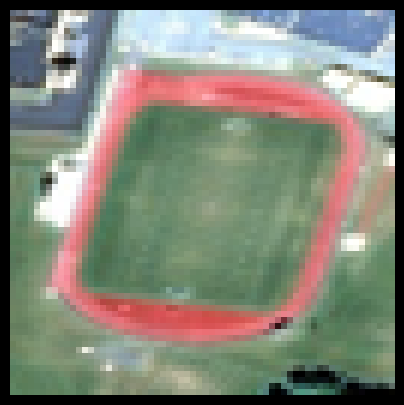

In [127]:
# load an image
# img_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRFQsDBSqgPKLHyunyQ0LJVDBXwzpnvWJqAOLPvVaUoA0xP-ZH4PPVCuyZtMllgEHSRTog&usqp=CAU'
# img_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQSEHLflglbuqe5FfipsPHIQHOSmDX46YBMQIt2yiIZteSj6k_bnnVtAgNGrSWIYAovuzM&usqp=CAU'
# img_data = requests.get(img_url, stream=True).raw

img = viz.prepare_image('./images/0.jpg', model)
plt.rcParams["figure.figsize"] = [5, 5]
viz.show_image(torch.tensor(img))

### Run MAE on the image

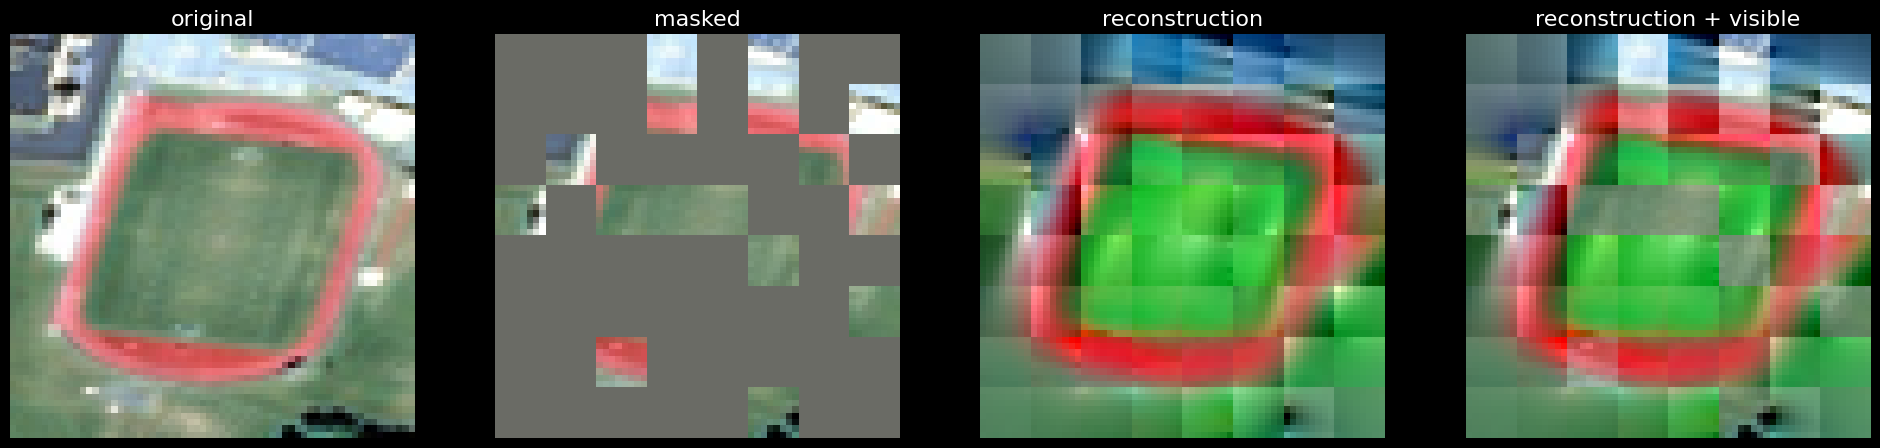

In [128]:
viz.run_one_image(img, model, seed=None)
# run_one_image(img, model_mae, seed=2)

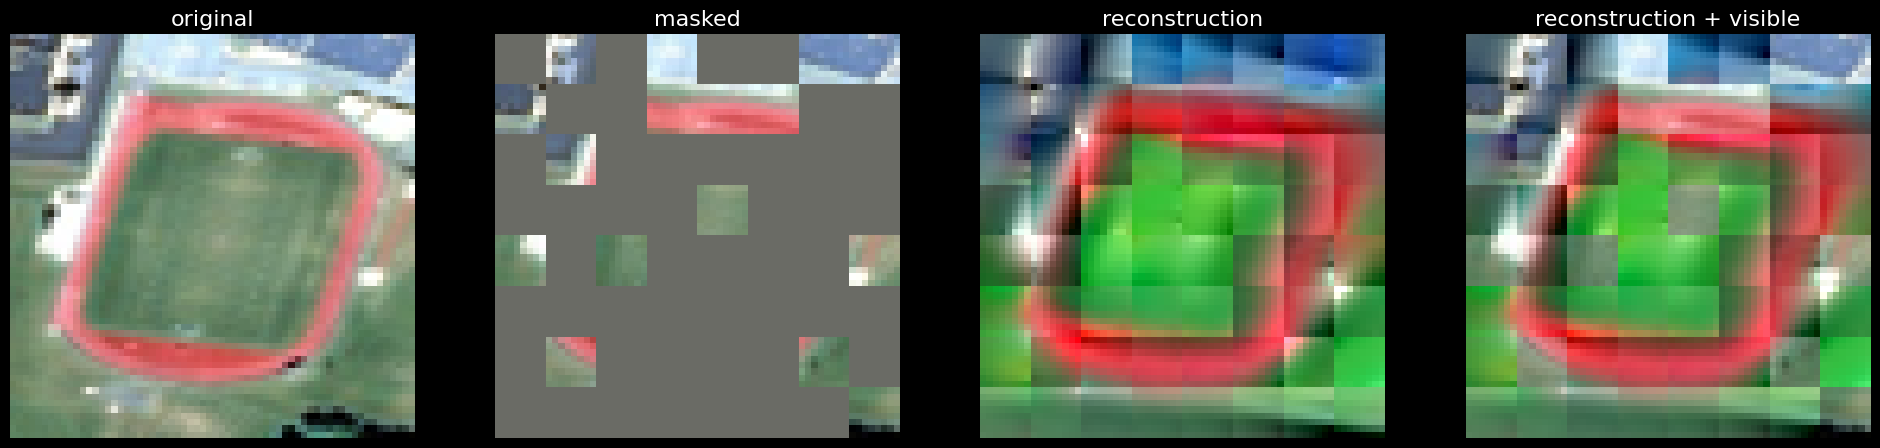

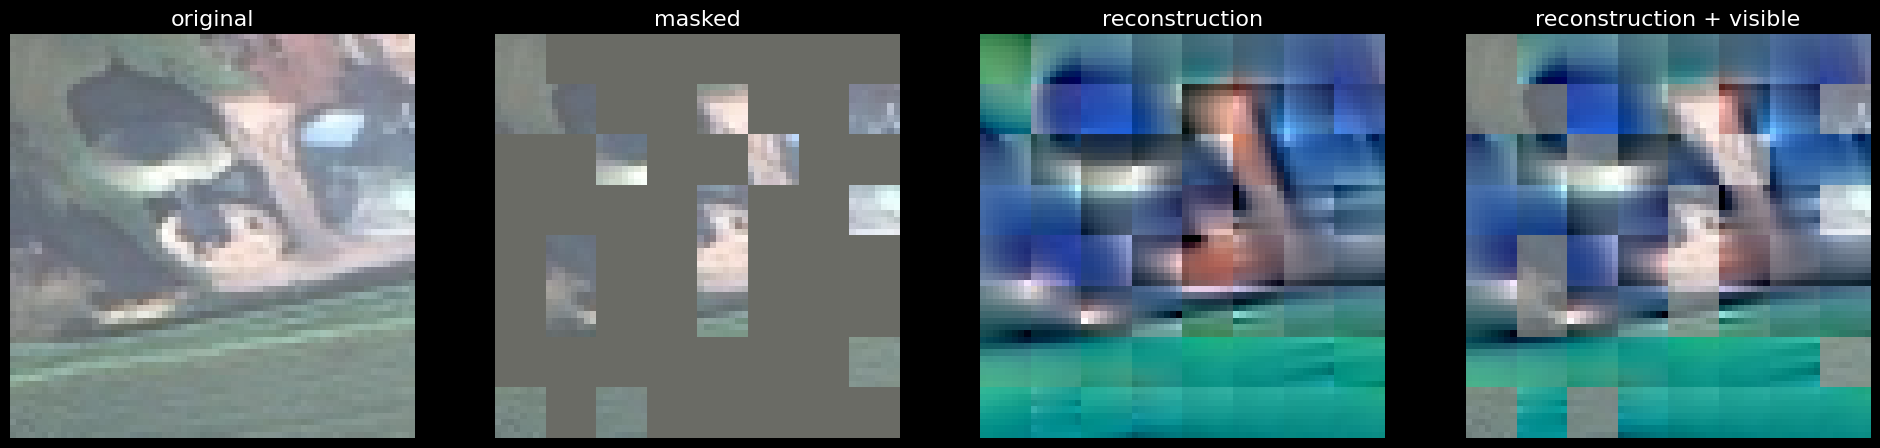

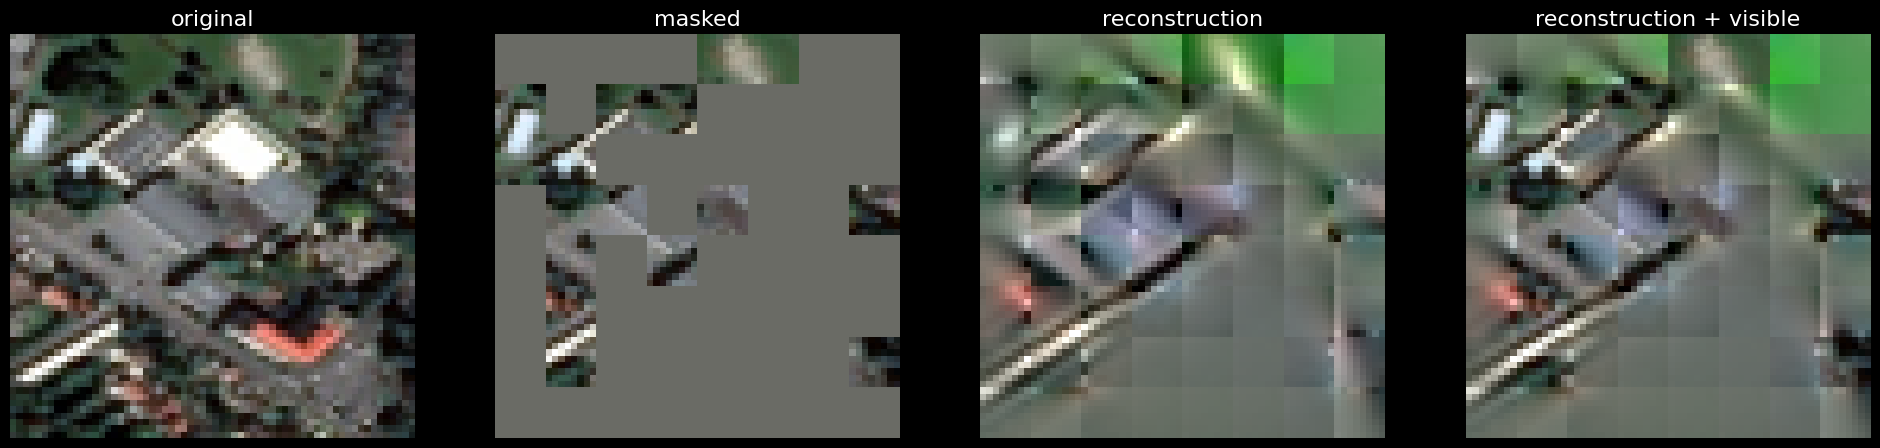

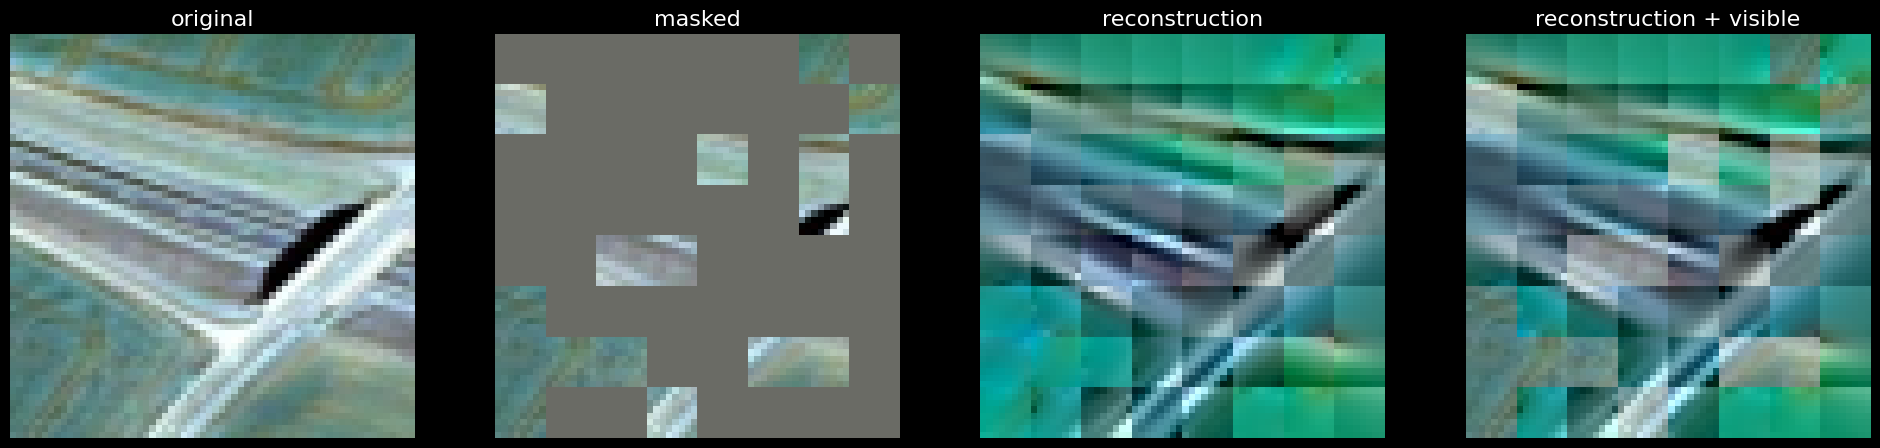

In [129]:

for img_path in glob.glob('./images/*.jpg'):
    img = viz.prepare_image(img_path, model)
    viz.run_one_image(img, model, seed=None)